# Weak imposition of Dirichlet Conditions for the poisson Problem.

- Set up a 2D unit square mesh.
- Prepare a function space over it (for solving PDEs)
- Load mathematical tools (UFL) to express differential equations
- Get MPI ready for parallel computing
- Prepare to solve linear PDEs using PETSc

In [1]:
from dolfinx import fem, mesh, plot, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import numpy
from mpi4py import MPI
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction, div, dx, ds, grad, inner)
N = 8
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = fem.functionspace(domain, ("Lagrange",1))

### 🔍 Explanation of Code Block

This code defines a known (exact) solution to the Poisson equation and uses it to compute:

- A Dirichlet boundary condition (`uD`)
- The right-hand side source term `f`

By comparing the calculated solution to the known exact solution, this configuration is commonly used to confirm that a numerical solver is accurate.

In [2]:
# Create an empty function uD in the function space V
# This will be used to impose Dirichlet boundary conditions
uD = fem.Function(V)

# Get symbolic spatial coordinates (x, y) for the domain
x = SpatialCoordinate(domain)

# Define the exact (manufactured) solution u(x, y) = 1 + x^2 + 2y^2
u_ex = 1 + x[0]**2 + 2*x[1]**2

# Interpolate the exact solution into the finite element function uD
# This assigns values to uD at the element nodes
uD.interpolate(fem.Expression(u_ex, V.element.interpolation_points()))

# Compute the source term f = -div(grad(u_ex)) = -Δu_ex
# This ensures that u_ex satisfies the PDE: -Δu = f
f = -div(grad(u_ex))

## 📘 Derivation of the Weak Form (Poisson Equation with Weak Dirichlet Conditions)

We consider the **Poisson equation**:

$$
- \Delta u = f \quad \text{in } \Omega, \qquad u = u_D \quad \text{on } \partial\Omega
$$

---

### 🔹 Step 1: Multiply by a Test Function

Multiply both sides by a test function $v$ and integrate over the domain:

$$
\int_{\Omega} (-\Delta u) v \, dx = \int_{\Omega} f v \, dx
$$

---

### 🔹 Step 2: Apply Integration by Parts (Green’s Identity)

$$
\int_{\Omega} \nabla u \cdot \nabla v \, dx - \int_{\partial \Omega} \nabla u \cdot n\, v \, ds = \int_{\Omega} f v \, dx
$$

This gives us Equation (8) from the reference.

---

### 🔹 Step 3: Traditional Weak Form (Strong Dirichlet)

If we enforce $v = 0$ on $\partial \Omega$, the boundary term vanishes:

$$
\int_{\Omega} \nabla u \cdot \nabla v \, dx = \int_{\Omega} f v \, dx
$$

---

### 🔹 Step 4: Weak Enforcement via Nitsche’s Method

Instead of forcing $u = u_D$, we allow deviations and **add the following boundary terms**:

$$
- \int_{\partial\Omega} \nabla v \cdot n (u - u_D) \, ds
+ \frac{\alpha}{h} \int_{\partial\Omega} (u - u_D) v \, ds
$$

Where:
- $\alpha > 0$ is a penalty parameter.
- $h$ is the mesh element size.

---

### 🔹 Step 5: Full Weak Form

#### ✅ Bilinear Form $a(u, v)$:

$$
a(u, v) =
\int_{\Omega} \nabla u \cdot \nabla v \, dx
+ \int_{\partial \Omega} \left[
- (\nabla u \cdot n)v - (\nabla v \cdot n)u + \frac{\alpha}{h} u v
\right] \, ds
$$

#### ✅ Linear Form $L(v)$:

$$
L(v) =
\int_{\Omega} f v \, dx
+ \int_{\partial \Omega} \left[
- (\nabla v \cdot n) u_D + \frac{\alpha}{h} u_D v
\right] \, ds
$$

---

### ✅ Summary

| Term | Meaning |
|------|---------|
| $\int_\Omega \nabla u \cdot \nabla v \, dx$ | Standard PDE interior term |
| $- (\nabla u \cdot n)v$, $- (\nabla v \cdot n)u$ | Enforces symmetry of the formulation |
| $\frac{\alpha}{h} u v$ | Penalizes deviation from Dirichlet condition |
| RHS terms with $u_D$ | Replace unknown $u$ with known data |

This method **weakly enforces the boundary condition** and maintains symmetry and stability of the solution.


In [3]:
u = TrialFunction(V)  # Define the trial function (solution) from the finite element space V
v = TestFunction(V)   # Define the test function (weight function) from the same space V

n = FacetNormal(domain)  # Outward-pointing unit normal vector on the boundary facets of the domain

h = 2 * Circumradius(domain)  # Characteristic element size (used in stabilization), typically twice the circumradius of elements

alpha = fem.Constant(domain, default_scalar_type(10))  
# Penalty parameter for Nitsche's method; large enough to ensure stability and weak enforcement of Dirichlet BC

# Bilinear form 'a' (left-hand side of the variational problem)
a = inner(grad(u), grad(v)) * dx                    # Standard inner product of gradients (∇u · ∇v) over the domain
a += - inner(n, grad(u)) * v * ds                   # Surface term from integration by parts (natural BC contribution)
a += - inner(n, grad(v)) * u * ds                   # Symmetric term for Nitsche's method (ensures consistency)
a += alpha/h * inner(u, v) * ds                     # Penalty term (stabilizes the weak enforcement of Dirichlet BC)

# Linear form 'L' (right-hand side of the variational problem)
L = inner(f, v) * dx                                # Forcing term (e.g., source term f)
L += - inner(n, grad(v)) * uD * ds                  # Boundary term involving prescribed Dirichlet value uD
L += alpha / h * inner(uD, v) * ds                  # Penalty term involving uD for Nitsche's method

### As we now have the variational form, we can solve the linear problem

In [4]:
problem = LinearProblem(a, L)
uh = problem.solve()

In [5]:
print(type(uh))

<class 'dolfinx.fem.function.Function'>


### We compute the error of the computation by comparing it to the analytical solution

In [6]:
error_form = fem.form(inner(uh - uD, uh - uD) * dx)
# Define the squared L2 error integrand: ∫(uh - uD)² dx
# 'uh' is the numerical solution, 'uD' is the exact or reference solution
# 'inner(uh - uD, uh - uD)' gives the squared difference

error_local = fem.assemble_scalar(error_form)
# Assemble the local contribution to the integral over this process's portion of the domain

errorl2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
# Use MPI to sum up the local errors across all processes (parallel computing)
# Take the square root to compute the final L2 norm: ||uh - uD||_{L2}

if domain.comm.rank == 0:
    print(fr"$L^2$-error: {errorl2:.2e}")
# Only the root process (rank 0) prints the error
# The output is formatted in scientific notation with 2 decimal digits


$L^2$-error: 1.59e-03


We observe that the $L^2$ error is of the same magnitude as in the first tutorial. As in the previous tutorial, we also compute the maximal error for all the degrees of freedom.

In [7]:
error_max = domain.comm.allreduce(numpy.max(numpy.abs(uD.x.array-uh.x.array)), op=MPI.MAX)
if domain.comm.rank == 0:
    print(f"Error_max : {error_max:.2e}")

Error_max : 5.41e-03


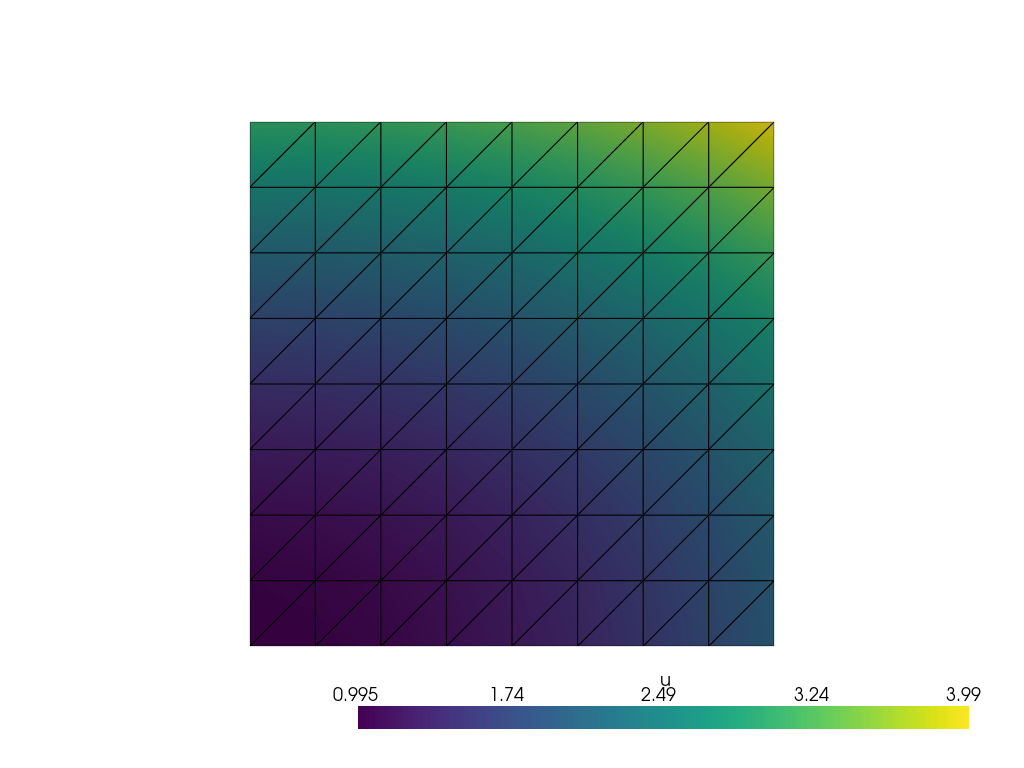

In [11]:
# Import the PyVista library, which is used for 3D plotting and mesh visualization
import pyvista

# Start a virtual X framebuffer (Xvfb) for off-screen rendering (useful for headless environments like servers)
pyvista.start_xvfb()

# Create a PyVista UnstructuredGrid from the VTK mesh returned by plot.vtk_mesh(V)
# The asterisk (*) unpacks the tuple returned by plot.vtk_mesh(V) as arguments
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))

# Assign the real part of the solution 'uh' to the grid's point data under the name "u"
grid.point_data["u"] = uh.x.array.real

# Set the active scalar array for visualization to be "u"
grid.set_active_scalars("u")

# Create a new PyVista plotter for rendering the mesh
plotter = pyvista.Plotter()

# Add the mesh to the plotter with edge lines and a scalar bar for the active scalar
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)

# Set the camera view to be perpendicular to the XY plane
plotter.view_xy()

# If rendering is not off-screen, display the interactive plot window

plotter.show()
# Otherwise, take a screenshot of the plot and save it to "nitsche.png"
figure = plotter.screenshot("nitsche.png")


In [9]:
import os
print(os.getcwd())

/home/shoykot-amanat/finics/fenicsTutorials


In [12]:
print(os.listdir())

['poisoon_problem_2.ipynb', '.ipynb_checkpoints', 'nitsche.png']
